# Importing Packages

Import packages

In [186]:
import pandas as pd
import numpy as np
import tqdm
import nltk
import time
import random
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from PIL import Image

In [187]:
import keras as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Recall, Precision

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Load Data and Preprocess

Load the messages

In [188]:
df = pd.read_csv('messages.csv')
df.head()
df_orig = df.copy()

In [189]:
df_orig.shape

(5572, 2)

In [190]:
pd.set_option('display.max_colwidth', None)

print(df_orig.head(5))

  Category  \
0      ham   
1      ham   
2     spam   
3      ham   
4      ham   

                                                                                                                                                       Message  
0                                              Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...  
1                                                                                                                                Ok lar... Joking wif u oni...  
2  Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's  
3                                                                                                            U dun say so early hor... U c already then say...  
4                                                                                                Nah I don't t

In [191]:
df_orig.drop_duplicates(subset=['Message'], keep='first', inplace=True)

In [192]:
df_orig.shape

(5157, 2)

In [193]:
df_orig.value_counts('Category', normalize=True)

Category
ham     0.875703
spam    0.124297
dtype: float64

Create a binary target where 1 = Spam and 0 = Ham. Rename the columns.

In [194]:
df['target'] = [1 if x=='spam' else 0 for  x in df.Category]
df.drop('Category', axis=1, inplace=True)
df.columns = ['message','target']
df_spam = df[df.target==1]
df_ham = df[df.target==0]

Observe the baseline accuracy

In [195]:
df.target.value_counts(normalize=True)

0    0.865937
1    0.134063
Name: target, dtype: float64

Baseline is 86.6%

Define X and y datasets, or predictors and target datasets.

In [196]:
X= df.message
y= df.target

I have left punctuation and non-alphanumeric characters in here for now because they are harmless. The Tensorflow Tokenizer can deal with them. 

# EDA Plots

In [197]:
df_orig['word_count'] = df_orig.Message.apply(lambda x: len(x.split(' ')))

In [198]:
df_orig.groupby('Category').mean()

,word_count
Category,
ham,14.328388
spam,23.659906


In [199]:
df_orig.groupby('Category')['word_count'].agg(['count','mean','median'])

,count,mean,median
Category,,,
ham,4516,14.328388,11.0
spam,641,23.659906,25.0


In [200]:
df_orig.groupby('Category').count()

,Message,word_count
Category,,
ham,4516,4516
spam,641,641


In [201]:
df_orig.sample(5)

,Category,Message,word_count
3424,spam,Had your mobile 10 mths? Update to latest Orange camera/video phones for FREE. Save £s with Free texts/weekend calls. Text YES for a callback orno to opt out,28
4334,ham,Y bishan lei... I tot ü say lavender?,8
2183,ham,PS U no ur a grown up now right?,9
966,ham,Or better still can you catch her and let ask her if she can sell &lt;#&gt; for me.,20
1923,ham,I'll be in sch fr 4-6... I dun haf da book in sch... It's at home...,16


In [202]:
for i in random.sample(range(0,4825),5):
    print(df_ham.index[i], df_ham.iloc[i,0])
print('')
for i in random.sample(range(0,747),5):
    print(df_spam.index[i], df_spam.iloc[i,0])

1040 They just talking thats it de. They wont any other.
2122 In xam hall boy asked girl Tell me the starting term for dis answer I can den manage on my own After lot of hesitation n lookin around silently she said THE! intha ponnungale ipaditan;)
4791 Yup. Izzit still raining heavily cos i'm in e mrt i can't c outside.
2485 Only if you promise your getting out as SOON as you can. And you'll text me in the morning to let me know you made it in ok.
4052 Motivate Behind every darkness, there is a shining light waiting for you to find it... Behind every best friend, there is always trust and love... BSLVYL

4949 Hi this is Amy, we will be sending you a free phone number in a couple of days, which will give you an access to all the adult parties...
3092 LORD OF THE RINGS:RETURN OF THE KING in store NOW!REPLY LOTR by 2 June 4 Chance 2 WIN LOTR soundtrack CDs StdTxtRate. Reply STOP to end txts
5427 Santa Calling! Would your little ones like a call from Santa Xmas eve? Call 09058094583 to boo

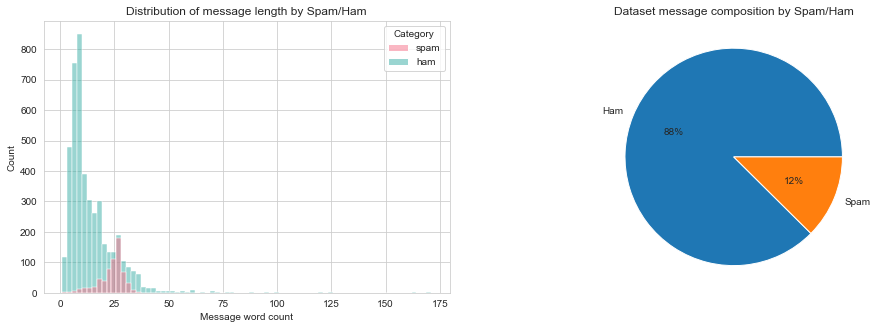

In [203]:
# Plot message length by spam/ham

df_orig['Category'] = pd.Categorical(df_orig['Category'], ['spam','ham'])
sns.set_style("whitegrid")

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(16,5))
sns.histplot(data=df_orig, 
             x="word_count",
             hue="Category",
             palette='husl',
             bins=75,
             ax=ax[0],
             legend=True).set_title('Distribution of message length by Spam/Ham')
ax[0].set_xlabel('Message word count')
ax[0].set_ylabel('Count')
colors = sns.color_palette('husl')

ax[1].pie(df_orig.Category.value_counts(normalize=True), labels = ['Ham','Spam'], autopct='%0.f%%')
ax[1].set_title('Dataset message composition by Spam/Ham')
plt.savefig('images/eda.png',bbox_inches='tight',dpi=400, pad_inches=0.1)
plt.show()

In [204]:
df_orig.sort_values(by='word_count', ascending=False)

,Category,Message,word_count
1085,ham,For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later..,171
1863,ham,"The last thing i ever wanted to do was hurt you. And i didn't think it would have. You'd laugh, be embarassed, delete the tag and keep going. But as far as i knew, it wasn't even up. The fact that you even felt like i would do it to hurt you shows you really don't know me at all. It was messy wednesday, but it wasn't bad. The problem i have with it is you HAVE the time to clean it, but you choose not to. You skype, you take pictures, you sleep, you want to go out. I don't mind a few things here and there, but when you don't make the bed, when you throw laundry on top of it, when i can't have a friend in the house because i'm embarassed that there's underwear and bras strewn on the bed, pillows on the floor, that's something else. You used to be good about at least making the bed.",162
2158,ham,"Sad story of a Man - Last week was my b'day. My Wife did'nt wish me. My Parents forgot n so did my Kids . I went to work. Even my Colleagues did not wish. As I entered my cabin my PA said, '' Happy B'day Boss !!''. I felt special. She askd me 4 lunch. After lunch she invited me to her apartment. We went there. She said,'' do u mind if I go into the bedroom for a minute ? '' ''OK'', I sed in a sexy mood. She came out 5 minuts latr wid a cake...n My Wife, My Parents, My Kidz, My Friends n My Colleagues. All screaming.. SURPRISE !! and I was waiting on the sofa.. ... ..... ' NAKED...!",125
1579,ham,How to Make a girl Happy? It's not at all difficult to make girls happy. U only need to be... 1. A friend 2. Companion 3. Lover 4. Chef . . . &lt;#&gt; . Good listener &lt;#&gt; . Organizer &lt;#&gt; . Good boyfriend &lt;#&gt; . Very clean &lt;#&gt; . Sympathetic &lt;#&gt; . Athletic &lt;#&gt; . Warm . . . &lt;#&gt; . Courageous &lt;#&gt; . Determined &lt;#&gt; . True &lt;#&gt; . Dependable &lt;#&gt; . Intelligent . . . &lt;#&gt; . Psychologist &lt;#&gt; . Pest exterminator &lt;#&gt; . Psychiatrist &lt;#&gt; . Healer . . &lt;#&gt; . Stylist &lt;#&gt; . Driver . . Aaniye pudunga venaam..,121
2434,ham,"Indians r poor but India is not a poor country. Says one of the swiss bank directors. He says that "" &lt;#&gt; lac crore"" of Indian money is deposited in swiss banks which can be used for 'taxless' budget for &lt;#&gt; yrs. Can give &lt;#&gt; crore jobs to all Indians. From any village to Delhi 4 lane roads. Forever free power suply to more than &lt;#&gt; social projects. Every citizen can get monthly &lt;#&gt; /- for &lt;#&gt; yrs. No need of World Bank &amp; IMF loan. Think how our money is blocked by rich politicians. We have full rights against corrupt politicians. Itna forward karo ki pura INDIA padhe.g.m.""",119
...,...,...,...
284,ham,Okie...,1
2908,ham,ALRITE,1
2508,ham,Yup...,1
783,ham,Beerage?,1


# Tensorflow Modelling

In [205]:
# https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/

In [206]:
SEQUENCE_LENGTH = 50 # the length of all sequences (number of words per sample)
EMBEDDING_SIZE = 100  # Using 100-Dimensional GloVe embedding vectors
TEST_SIZE = 0.25 # ratio of testing set

BATCH_SIZE = 64
EPOCHS = 20 # number of epochs

## Tokenize

In [207]:
# Text tokenization - we have to do this before obtaining the word embeddings 
# https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

# vectorizing text, turning each text into sequence of integers. 
# Default behaviour is to filter all punctuation, plus tabs and line breaks, minus the ' character.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
# convert to sequence of integers
X = tokenizer.texts_to_sequences(X)

# Save this dictionary for later
word_index = tokenizer.word_index

In [208]:
print(X[1])

[46, 336, 1499, 472, 6, 1940]


In [209]:
# convert to numpy arrays
# X = np.array(X)
# y = np.array(y)
# pad sequences at the beginning of each sequence with 0's
# for example if SEQUENCE_LENGTH=4:
# [[5, 3, 2], [5, 1, 2, 3], [3, 4]]
# will be transformed to:
# [[0, 5, 3, 2], [5, 1, 2, 3], [0, 0, 3, 4]]
X = pad_sequences(sequences=X, 
                  maxlen=SEQUENCE_LENGTH, 
                  padding='pre', 
                  truncating='post')

In [210]:
print(X[1])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0   46  336 1499  472    6 1940]


In [211]:
print(X.shape)

(5572, 50)


Discuss what this 100 term is

In [212]:
X

array([[   0,    0,    0, ...,   58, 4427,  144],
       [   0,    0,    0, ...,  472,    6, 1940],
       [   0,    0,    0, ...,  660,  391, 2994],
       ...,
       [   0,    0,    0, ...,  107,  250, 9003],
       [   0,    0,    0, ...,  198,   12,   47],
       [   0,    0,    0, ...,    2,   61,  267]], dtype=int32)

In [213]:
y

0       0
1       0
2       1
3       0
4       0
       ..
5567    1
5568    0
5569    0
5570    0
5571    0
Name: target, Length: 5572, dtype: int64

## Train-Test Split

In [214]:
# split and shuffle
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=5)
# print our data shapes
print("X_train.shape:", X_train.shape)
print("X_test.shape:", X_test.shape)
print("y_train.shape:", y_train.shape)
print("y_test.shape:", y_test.shape)

X_train.shape: (4179, 50)
X_test.shape: (1393, 50)
y_train.shape: (4179,)
y_test.shape: (1393,)


## Word Embedding Using GloVe

I'm using a pre-trained [GloVe word embedding](https://nlp.stanford.edu/projects/glove/) dataset in 100 dimensional space, saved outside of this repository. 

This function opens the GloVe file and maps each of the tokenized words to the corresponding embedded vector. This process works to encode meanings of words in a way that causes words of comparable meaning to be expressed similarly in the defined vector space. More can be read about word embedding [here](https://machinelearningmastery.com/what-are-word-embeddings/).

In [215]:
# https://machinelearningmastery.com/what-are-word-embeddings/
# https://nlp.stanford.edu/projects/glove/

def get_embedding_vectors(tokenizer, dim=100):
    embedding_index = {}
    with open(f"../data/glove.6B.{dim}d.txt", encoding='utf8') as f:
        for line in tqdm.tqdm(f, "Reading GloVe"):
            values = line.split()
            word = values[0]
            vectors = np.asarray(values[1:], dtype='float32')
            embedding_index[word] = vectors

    word_index = tokenizer.word_index
    embedding_matrix = np.zeros((len(word_index)+1, dim))
    for word, i in word_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            # words not found will be 0s
            embedding_matrix[i] = embedding_vector
            
    return embedding_matrix

## LSTM Model Definition

Define a list of metrics to be used later in the model definition. These will be calculated and saved after each epoch in the model build for visibility on the modelling process.

In [216]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR')] # precision-recall curve

Now to define the Keras model. I'm going to do this using the [sequential model API](https://machinelearningmastery.com/keras-functional-api-deep-learning/) where Sequential class is created and model layers are then added to it. The steps I use are as follows:
* Embed the tokenized words
* Add a user defined number of Long Short-Term Memory units 
* Add a Dropout feature of 0.3 to combat over-fitting <-- Bob to find out what this really does
* Output one dense layer with a sigmoid activation function for 1/0 classification
* Compile the model using [binary crossentropy](https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/) as the loss function and rmsprop optimizer, reporting the extensive list of metrics after each epoch <-- Bob to find out what this really does

With training the model through back-propagation, RNNs famously suffer from the vanishing gradient problem. This means that the RNN would struggle to learn long-range dependencies from the early layers and is often described as a short-term memory problem. To combat this we used specialised units within the hidden layers - Long Short-Term Memory units or LSTMs. These LSTMs are able to learn long-range dependencies through a series of gated tensor operations which dictate what information to add or remove from the hidden state at each unit. 
<br>
<br>
<img src="images/LSTM.png" width=400 height=400 />
<center><sub>This is a graphical representation of a single LSTM unit. The sigma and tanh cells represent sigmoid and hyperbolic tangent functions respectively. X_t and h_t are the input vector and output value of the LSTM unit. </sub></center>

In [255]:
def get_model(tokenizer, lstm_units):
    """
    Constructs the model,
    Embedding vectors => LSTM => 1 output Fully-Connected neurons with sigmoid activation
    """
    # get the GloVe embedding vectors
    embedding_matrix = get_embedding_vectors(tokenizer)
    # we're going to define the model sequentially https://machinelearningmastery.com/keras-functional-api-deep-learning
    model = Sequential()
    # First, embed the words using loaded GloVe
    model.add(Embedding(len(tokenizer.word_index)+1,
              EMBEDDING_SIZE,
              weights=[embedding_matrix],
              trainable=False,
              mask_zero=True,
              input_length=SEQUENCE_LENGTH))
    # Add long short-term memory units
    model.add(LSTM(lstm_units, recurrent_dropout=0.2))
    # Add dropout to combat overfitting
    model.add(Dropout(0.2))
    # Add output dense layer with sigmoid for 1/0 classification
    model.add(Dense(1, activation="sigmoid"))
    # compile as rmsprop optimizer
    # aswell as with recall metric
    model.compile(optimizer="rmsprop", 
                  loss="binary_crossentropy",
                  metrics=[METRICS])

    model.summary()
    return model

def get_bidirectional_model(tokenizer, lstm_units):
    """
    Constructs the model,
    Embedding vectors => Bi-LSTM => 1 output Fully-Connected neuron with sigmoid activation
    """
    # get the GloVe embedding vectors
    embedding_matrix = get_embedding_vectors(tokenizer)
    # we're going to define the model sequentially https://machinelearningmastery.com/keras-functional-api-deep-learning
    model = Sequential()
    # First, embed the words using loaded GloVe
    model.add(Embedding(len(tokenizer.word_index)+1,
              EMBEDDING_SIZE,
              weights=[embedding_matrix],
              trainable=True,
              mask_zero=True,
              input_length=SEQUENCE_LENGTH))
    # Add bidirectional long short-term memory units
    model.add(Bidirectional(LSTM(lstm_units, recurrent_dropout=0.2)))
    # Add dropout to combat overfitting
    model.add(Dropout(0.2))
    # Add output dense layer with sigmoid for 1/0 classification
    model.add(Dense(1, activation="sigmoid"))
    # compile as rmsprop optimizer
    # aswell as with recall metric
    model.compile(optimizer="rmsprop", 
                  loss="binary_crossentropy",
                  metrics=[METRICS])

    model.summary()
    return model

Call the `get_model` function to generate the skeleton - not trained yet.

In [256]:
# constructs the model with 128 LSTM units
model = get_model(tokenizer=tokenizer, lstm_units=128)

Reading GloVe: 400001it [00:08, 49296.35it/s]


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 50, 100)           900500    
                                                                 
 lstm_11 (LSTM)              (None, 128)               117248    
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1,017,877
Trainable params: 117,377
Non-trainable params: 900,500
_________________________________________________________________


In [257]:
# constructs the bidirectional-model with 128 LSTM units
bimodel = get_bidirectional_model(tokenizer=tokenizer, lstm_units=128)

Reading GloVe: 400001it [00:07, 50774.81it/s]


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 50, 100)           900500    
                                                                 
 bidirectional_6 (Bidirectio  (None, 256)              234496    
 nal)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 256)               0         
                                                                 
 dense_12 (Dense)            (None, 1)                 257       
                                                                 
Total params: 1,135,253
Trainable params: 1,135,253
Non-trainable params: 0
_________________________________________________________________


Initialise required TensorBoard callbacks, best model_checkpoints and early stopping. Then fit the model using a batch size and number of epochs defined at the start of section 3. 

### LSTM Model Training

In [220]:
# initialize our ModelCheckpoint and TensorBoard callbacks
# model checkpoint for saving best weights
model_checkpoint = ModelCheckpoint("../results/spam_classifier_{val_loss:.2f}.h5", save_best_only=True,
                                    verbose=1)
# for better visualization
tensorboard = TensorBoard(log_dir=f"logs/spam_classifier_{time.time()}", histogram_freq=1)
%tensorboard --logdir ./logs

# define model stopping criteria
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, 
                                              restore_best_weights=True)
# train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
          batch_size=BATCH_SIZE, epochs=EPOCHS,
          callbacks=[tensorboard, model_checkpoint, early_stop],
          verbose=1)
%tensorboard --logdir logs/fit

# My tensorboard source https://www.youtube.com/watch?v=-9-Hy5dWKLE

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

Epoch 1/20
65/66 [============================>.] - ETA: 0s - loss: 0.1703 - tp: 388.0000 - fp: 65.0000 - tn: 3539.0000 - fn: 168.0000 - accuracy: 0.9440 - precision: 0.8565 - recall: 0.6978 - auc: 0.9446 - prc: 0.8450
Epoch 1: val_loss improved from inf to 0.17572, saving model to ../results/spam_classifier_0.18.h5
66/66 [==============================] - 9s 84ms/step - loss: 0.1716 - tp: 389.0000 - fp: 65.0000 - tn: 3555.0000 - fn: 170.0000 - accuracy: 0.9438 - precision: 0.8568 - recall: 0.6959 - auc: 0.9429 - prc: 0.8432 - val_loss: 0.1757 - val_tp: 178.0000 - val_fp: 74.0000 - val_tn: 1131.0000 - val_fn: 10.0000 - val_accuracy: 0.9397 - val_precision: 0.7063 - val_recall: 0.9468 - val_auc: 0.9855 - val_prc: 0.9537
Epoch 2/20
66/66 [==============================] - ETA: 0s - loss: 0.0932 - tp: 481.0000 - fp: 44.0000 - tn: 3576.0000 - fn: 78.0000 - accuracy: 0.9708 - precision: 0.9162 - recall: 0.8605 - auc: 0.9828 - prc: 0.9433
Epoch 2: val_loss improved from 0.17572 to 0.07940, s

Epoch 13/20
66/66 [==============================] - ETA: 0s - loss: 0.0156 - tp: 548.0000 - fp: 4.0000 - tn: 3616.0000 - fn: 11.0000 - accuracy: 0.9964 - precision: 0.9928 - recall: 0.9803 - auc: 0.9987 - prc: 0.9970
Epoch 13: val_loss did not improve from 0.04838
66/66 [==============================] - 5s 73ms/step - loss: 0.0156 - tp: 548.0000 - fp: 4.0000 - tn: 3616.0000 - fn: 11.0000 - accuracy: 0.9964 - precision: 0.9928 - recall: 0.9803 - auc: 0.9987 - prc: 0.9970 - val_loss: 0.0526 - val_tp: 172.0000 - val_fp: 4.0000 - val_tn: 1201.0000 - val_fn: 16.0000 - val_accuracy: 0.9856 - val_precision: 0.9773 - val_recall: 0.9149 - val_auc: 0.9844 - val_prc: 0.9738
Epoch 14/20
65/66 [============================>.] - ETA: 0s - loss: 0.0183 - tp: 540.0000 - fp: 8.0000 - tn: 3598.0000 - fn: 14.0000 - accuracy: 0.9947 - precision: 0.9854 - recall: 0.9747 - auc: 0.9976 - prc: 0.9953
Epoch 14: val_loss did not improve from 0.04838
66/66 [==============================] - 5s 74ms/step - loss

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

In [221]:
history.history

{'loss': [0.17160950601100922,
  0.09316686540842056,
  0.07632467895746231,
  0.06369034200906754,
  0.05595159903168678,
  0.04907062649726868,
  0.044334203004837036,
  0.03335994482040405,
  0.03372577950358391,
  0.029901156201958656,
  0.022482091560959816,
  0.022599564865231514,
  0.015597997233271599,
  0.01818058267235756,
  0.011139139533042908,
  0.013039199635386467,
  0.0115746408700943,
  0.00935744121670723,
  0.006837632041424513,
  0.006945199333131313],
 'tp': [389.0,
  481.0,
  488.0,
  506.0,
  513.0,
  516.0,
  521.0,
  528.0,
  524.0,
  533.0,
  539.0,
  543.0,
  548.0,
  545.0,
  551.0,
  550.0,
  551.0,
  550.0,
  552.0,
  555.0],
 'fp': [65.0,
  44.0,
  34.0,
  25.0,
  18.0,
  20.0,
  16.0,
  13.0,
  10.0,
  7.0,
  5.0,
  10.0,
  4.0,
  8.0,
  2.0,
  4.0,
  6.0,
  3.0,
  3.0,
  2.0],
 'tn': [3555.0,
  3576.0,
  3586.0,
  3595.0,
  3602.0,
  3600.0,
  3604.0,
  3607.0,
  3610.0,
  3613.0,
  3615.0,
  3610.0,
  3616.0,
  3612.0,
  3618.0,
  3616.0,
  3614.0,
  3

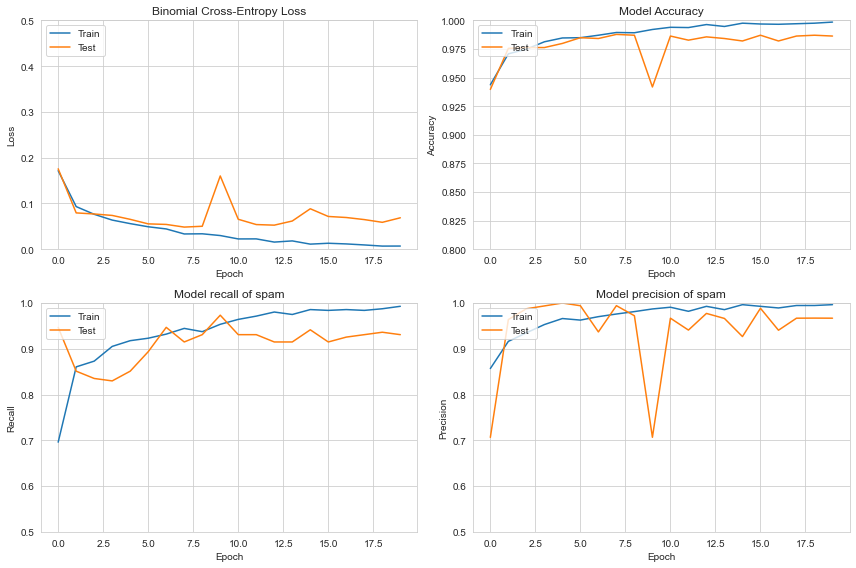

In [222]:
# Plot classification model performance metrics

fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(12,8))
ax[0,0].plot(history.history['loss'], label='Train')
ax[0,0].plot(history.history['val_loss'], label='Test')
ax[0,0].set_title('Binomial Cross-Entropy Loss')
ax[0,0].set_ylabel('Loss')
ax[0,0].set_ylim(0,0.5)
ax[0,0].set_xlabel('Epoch')
ax[0,0].legend(loc='upper left')
ax[0,1].plot(history.history['accuracy'], label='Train')
ax[0,1].plot(history.history['val_accuracy'], label='Test')
ax[0,1].set_title('Model Accuracy')
ax[0,1].set_ylabel('Accuracy')
ax[0,1].set_ylim(0.8,1)
ax[0,1].set_xlabel('Epoch')
ax[0,1].legend(loc='upper left')
ax[1,0].plot(history.history['recall'], label='Train')
ax[1,0].plot(history.history['val_recall'], label='Test')
ax[1,0].set_title('Model recall of spam')
ax[1,0].set_ylabel('Recall')
ax[1,0].set_ylim(0.5,1)
ax[1,0].set_xlabel('Epoch')
ax[1,0].legend(loc='upper left')
ax[1,1].plot(history.history['precision'], label='Train')
ax[1,1].plot(history.history['val_precision'], label='Test')
ax[1,1].set_title('Model precision of spam')
ax[1,1].set_ylabel('Precision')
ax[1,1].set_ylim(0.5,1)
ax[1,1].set_xlabel('Epoch')
ax[1,1].legend(loc='upper left')
plt.tight_layout()
plt.show()

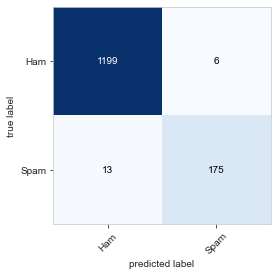

In [223]:
# Plot confusion matrix

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

y_pred = (model.predict(X_test) > 0.5).astype("int32")

plot_confusion_matrix(confusion_matrix(y_test, y_pred), class_names=['Ham','Spam']);

In [227]:
# get the loss and metrics
result = model.evaluate(X_test, y_test)
# extract those
loss = result[0]
accuracy = result[5]
precision = result[6]
recall = result[7]
f1 = (2*precision*recall)/(precision+recall)

print(f"Accuracy:    {accuracy*100:.2f}%")
print(f"Precision:   {precision*100:.2f}%")
print(f"Recall:      {recall*100:.2f}%")
print(f"F1 Score:    {f1*100:.2f}%")

44/44 [==============================] - 0s 11ms/step - loss: 0.0687 - tp: 175.0000 - fp: 6.0000 - tn: 1199.0000 - fn: 13.0000 - accuracy: 0.9864 - precision: 0.9669 - recall: 0.9309 - auc: 0.9823 - prc: 0.9709
Accuracy:    98.64%
Precision:   96.69%
Recall:      93.09%
F1 Score:    94.85%


In [40]:
def get_predictions(text):
    sequence = tokenizer.texts_to_sequences([text])
    # pad the sequence
    sequence = pad_sequences(sequence, maxlen=SEQUENCE_LENGTH)
    # get the prediction
    prediction = model.predict(sequence)[0]
    # one-hot encoded vector, revert using np.argmax
    return int2label[np.argmax(prediction)]

In [41]:
int2label = {0: "ham", 1: "spam"}

text = "You won a prize of 1,000$, click here to claim!"
get_predictions(text)

'ham'

In [42]:
text = "Hi man, I was wondering if we can meet tomorrow."
print(get_predictions(text))

ham


In [43]:
probs = list(model.predict(X_test))
outcome = [0 if x[0]<0.5 else 1 for x in list(probs)]
dfpred = pd.DataFrame({'true': y_test,'pred':outcome})

In [44]:
dfpred

,true,pred
83,0,0
2235,0,0
2746,0,0
246,0,0
3120,0,0
...,...,...
1150,0,0
2989,0,0
1895,1,0
3064,1,1


In [45]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score

print(confusion_matrix(dfpred.true, dfpred.pred))
print('Accuracy',accuracy_score(dfpred.true, dfpred.pred))
print('Recall',recall_score(dfpred.true, dfpred.pred))
print('Precision',precision_score(dfpred.true, dfpred.pred))

[[1194    7]
 [  22  170]]
Accuracy 0.9791816223977028
Recall 0.8854166666666666
Precision 0.96045197740113


[Intersting link on explaining feature importance, although I don't know how it will work with the word embedder](https://github.com/slundberg/shap#deep-learning-example-with-deepexplainer-tensorflowkeras-models)

### Bidirectional LSTM Model Training

In [258]:
# initialize our ModelCheckpoint and TensorBoard callbacks
# model checkpoint for saving best weights
model_checkpoint = ModelCheckpoint("../results/spam_classifier_{val_loss:.2f}.h5", save_best_only=True,
                                    verbose=1)
# for better visualization
tensorboard = TensorBoard(log_dir=f"logs/spam_classifier_{time.time()}", histogram_freq=1)
%tensorboard --logdir ./logs

# define model stopping criteria
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, 
                                              restore_best_weights=True)
# train the model
history = bimodel.fit(X_train, y_train, validation_data=(X_test, y_test),
          batch_size=BATCH_SIZE, epochs=EPOCHS,
          callbacks=[tensorboard, model_checkpoint, early_stop],
          verbose=1)
%tensorboard --logdir logs/fit

# My tensorboard source https://www.youtube.com/watch?v=-9-Hy5dWKLE

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

Epoch 1/20
66/66 [==============================] - ETA: 0s - loss: 0.1541 - tp: 581.0000 - fp: 78.0000 - tn: 4747.0000 - fn: 166.0000 - accuracy: 0.9562 - precision: 0.8816 - recall: 0.7778 - auc: 0.9676 - prc: 0.8938
Epoch 1: val_loss improved from inf to 0.07849, saving model to ../results/spam_classifier_0.08.h5
66/66 [==============================] - 16s 148ms/step - loss: 0.1541 - tp: 581.0000 - fp: 78.0000 - tn: 4747.0000 - fn: 166.0000 - accuracy: 0.9562 - precision: 0.8816 - recall: 0.7778 - auc: 0.9676 - prc: 0.8938 - val_loss: 0.0785 - val_tp: 156.0000 - val_fp: 5.0000 - val_tn: 1200.0000 - val_fn: 32.0000 - val_accuracy: 0.9734 - val_precision: 0.9689 - val_recall: 0.8298 - val_auc: 0.9832 - val_prc: 0.9610
Epoch 2/20
66/66 [==============================] - ETA: 0s - loss: 0.0683 - tp: 492.0000 - fp: 30.0000 - tn: 3590.0000 - fn: 67.0000 - accuracy: 0.9768 - precision: 0.9425 - recall: 0.8801 - auc: 0.9869 - prc: 0.9658
Epoch 2: val_loss did not improve from 0.07849
66/66

Epoch 13/20
66/66 [==============================] - ETA: 0s - loss: 6.4986e-04 - tp: 558.0000 - fp: 0.0000e+00 - tn: 3620.0000 - fn: 1.0000 - accuracy: 0.9998 - precision: 1.0000 - recall: 0.9982 - auc: 1.0000 - prc: 1.0000
Epoch 13: val_loss did not improve from 0.04138
66/66 [==============================] - 10s 145ms/step - loss: 6.4986e-04 - tp: 558.0000 - fp: 0.0000e+00 - tn: 3620.0000 - fn: 1.0000 - accuracy: 0.9998 - precision: 1.0000 - recall: 0.9982 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0818 - val_tp: 179.0000 - val_fp: 7.0000 - val_tn: 1198.0000 - val_fn: 9.0000 - val_accuracy: 0.9885 - val_precision: 0.9624 - val_recall: 0.9521 - val_auc: 0.9831 - val_prc: 0.9709
Epoch 14/20
66/66 [==============================] - ETA: 0s - loss: 2.5697e-04 - tp: 559.0000 - fp: 0.0000e+00 - tn: 3620.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000
Epoch 14: val_loss did not improve from 0.04138
66/66 [===========================

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

In [259]:
temp=get_embedding_vectors(tokenizer)
temp.shape

Reading GloVe: 400001it [00:08, 48777.05it/s]


(9005, 100)

In [260]:
len(tokenizer.word_index)+1

9005

In [261]:
history.history

{'loss': [0.15406200289726257,
  0.06831230968236923,
  0.044511351734399796,
  0.028678404167294502,
  0.019937651231884956,
  0.013194574043154716,
  0.007740601431578398,
  0.004946502391248941,
  0.0032086018472909927,
  0.005905408412218094,
  0.0005682581104338169,
  0.002720644697546959,
  0.0006498575676232576,
  0.00025697017554193735,
  0.0007946625701151788,
  0.00018657962209545076,
  0.00249639549292624,
  0.00017620966536924243,
  0.00016464365762658417,
  0.00015925441402941942],
 'tp': [581.0,
  492.0,
  520.0,
  534.0,
  539.0,
  550.0,
  553.0,
  554.0,
  558.0,
  559.0,
  559.0,
  557.0,
  558.0,
  559.0,
  558.0,
  559.0,
  558.0,
  559.0,
  559.0,
  559.0],
 'fp': [78.0,
  30.0,
  19.0,
  14.0,
  8.0,
  11.0,
  1.0,
  2.0,
  2.0,
  4.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0],
 'tn': [4747.0,
  3590.0,
  3601.0,
  3606.0,
  3612.0,
  3609.0,
  3619.0,
  3618.0,
  3618.0,
  3616.0,
  3620.0,
  3620.0,
  3620.0,
  3620.0,
  3620.0,
  362

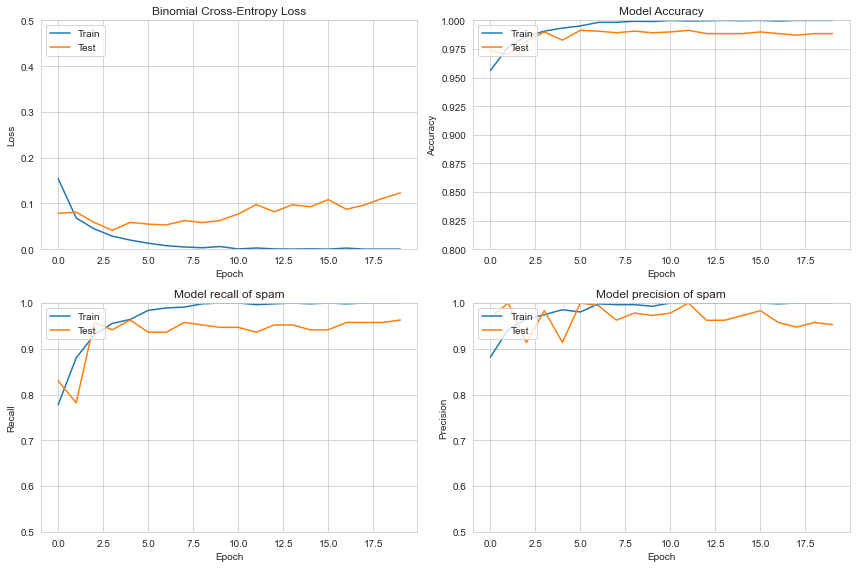

In [262]:
# Plot classification model performance metrics

fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(12,8))
ax[0,0].plot(history.history['loss'], label='Train')
ax[0,0].plot(history.history['val_loss'], label='Test')
ax[0,0].set_title('Binomial Cross-Entropy Loss')
ax[0,0].set_ylabel('Loss')
ax[0,0].set_ylim(0,0.5)
ax[0,0].set_xlabel('Epoch')
ax[0,0].legend(loc='upper left')
ax[0,1].plot(history.history['accuracy'], label='Train')
ax[0,1].plot(history.history['val_accuracy'], label='Test')
ax[0,1].set_title('Model Accuracy')
ax[0,1].set_ylabel('Accuracy')
ax[0,1].set_ylim(0.8,1)
ax[0,1].set_xlabel('Epoch')
ax[0,1].legend(loc='upper left')
ax[1,0].plot(history.history['recall'], label='Train')
ax[1,0].plot(history.history['val_recall'], label='Test')
ax[1,0].set_title('Model recall of spam')
ax[1,0].set_ylabel('Recall')
ax[1,0].set_ylim(0.5,1)
ax[1,0].set_xlabel('Epoch')
ax[1,0].legend(loc='upper left')
ax[1,1].plot(history.history['precision'], label='Train')
ax[1,1].plot(history.history['val_precision'], label='Test')
ax[1,1].set_title('Model precision of spam')
ax[1,1].set_ylabel('Precision')
ax[1,1].set_ylim(0.5,1)
ax[1,1].set_xlabel('Epoch')
ax[1,1].legend(loc='upper left')
plt.tight_layout()
plt.show()

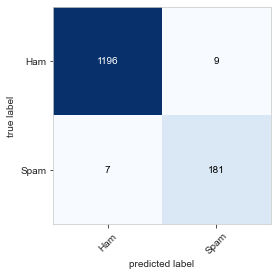

In [263]:
y_pred = (bimodel.predict(X_test) > 0.5).astype("int32")

plot_confusion_matrix(confusion_matrix(y_test, y_pred), class_names=['Ham','Spam']);

In [264]:
# # Plot confusion matrix

# from mlxtend.plotting import plot_confusion_matrix
# from sklearn.metrics import confusion_matrix

# y_pred = (bimodel.predict(X_test) > 0.5).astype("int32")

# plot_confusion_matrix(confusion_matrix(y_test, y_pred), class_names=['Ham','Spam']);

In [252]:
# get the loss and metrics
result = bimodel.evaluate(X_test, y_test)
# extract those
loss = result[0]
accuracy = result[5]
precision = result[6]
recall = result[7]
f1 = (2*precision*recall)/(precision+recall)

print(f"Accuracy:    {accuracy*100:.2f}%")
print(f"Precision:   {precision*100:.2f}%")
print(f"Recall:      {recall*100:.2f}%")
print(f"F1 Score:    {f1*100:.2f}%")

44/44 [==============================] - 1s 15ms/step - loss: 0.1172 - tp: 178.0000 - fp: 7.0000 - tn: 1198.0000 - fn: 10.0000 - accuracy: 0.9878 - precision: 0.9622 - recall: 0.9468 - auc: 0.9794 - prc: 0.9520
Accuracy:    98.78%
Precision:   96.22%
Recall:      94.68%
F1 Score:    95.44%


In [253]:
probs = list(bimodel.predict(X_test))
outcome = [0 if x[0]<0.5 else 1 for x in list(probs)]
dfpred = pd.DataFrame({'true': y_test,'pred':outcome})

In [254]:
# Sklearn metrics

print(confusion_matrix(dfpred.true, dfpred.pred))
print('Accuracy',accuracy_score(dfpred.true, dfpred.pred))
print('Recall',recall_score(dfpred.true, dfpred.pred))
print('Precision',precision_score(dfpred.true, dfpred.pred))

[[1198    7]
 [  10  178]]
Accuracy 0.9877961234745154
Recall 0.9468085106382979
Precision 0.9621621621621622


# Nice Word Clouds

In [54]:
vectorizer = CountVectorizer(token_pattern='[A-Za-z0-9]+(?=\\s+)',
                             ngram_range=(1,2))

In [55]:
vectorizer.fit(df.message)

CountVectorizer(ngram_range=(1, 2), token_pattern='[A-Za-z0-9]+(?=\\s+)')

In [56]:
# count word appearances
def word_counter(mat):
    count = np.array(mat.sum(axis=0))[0]
    return count

In [57]:
# sort words by frequency
from operator import itemgetter

def word_frequency_sorter(words, counts):
    sort_result = sorted(zip(words, list(counts)),
                         key=itemgetter(1), reverse=True)
    return sort_result

In [58]:
stop = stopwords.words('english')

# Series text column
tvec = TfidfVectorizer(stop_words = stop,
                       ngram_range = (1, 2),
                       max_features = 1000,
                       token_pattern = '[A-Za-z0-9]+(?=\\s+)',
                        )

# Fit vectorizer on text data
tvec.fit(df.message)

# Transform data
tvec_mat = tvec.transform(df.message)

# words occuring
words = tvec.get_feature_names_out()

# count word appearances
csum= word_counter(tvec_mat)

In [59]:
# sort words by frequency
df_word_frequency = pd.DataFrame(word_frequency_sorter(
    words, csum), columns=["word", "frequency_series"])
df_word_frequency.set_index('word', inplace=True)
df_word_frequency.index.name = None
df_word_frequency.head(20)

,frequency_series
u,202.879967
call,147.794835
get,113.840056
2,97.044550
ur,92.282646
come,86.105870
like,84.654699
got,83.499020
go,79.663331
know,75.688012


There are 453387 unique words in all the descriptions.


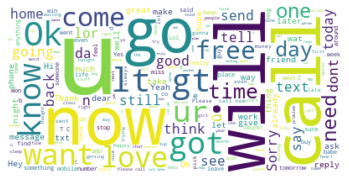

In [60]:
# all description text
wrds_cnt = " ".join(wrds for wrds in df.message)
print ("There are {} unique words in all the descriptions.".format(len(wrds_cnt)))

# create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["cnt","cnt"])

# create word cloud
wc_all = WordCloud(stopwords=stopwords,
                                  max_words=200,
                                  background_color="white")

# generate a word cloud image
wc_all.generate(wrds_cnt)

# display the generated image
plt.imshow(wc_all, interpolation='bilinear')
plt.axis("off")
plt.show()

There are 103824 unique words in all the descriptions.


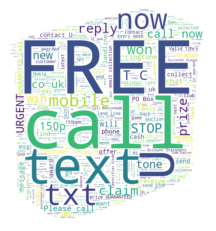

In [61]:
# all description text
wrds_cnt = " ".join(wrds for wrds in df_spam.message)
print ("There are {} unique words in all the descriptions.".format(len(wrds_cnt)))

# create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["cnt","cnt"])

# create word mask

mask_spam = np.array(Image.open('images/spam2.png'))

# create word cloud
wc_spam = WordCloud(stopwords=STOPWORDS,
               mask=mask_spam, background_color="white",
               max_words=2000, max_font_size=256,
               random_state=42, width=mask_spam.shape[1],
               height=mask_spam.shape[0])
wc_spam.generate(wrds_cnt)

# plot word cloud
plt.imshow(wc_spam, interpolation="bilinear")
plt.axis('off')
plt.show()

There are 349562 unique words in all the descriptions.


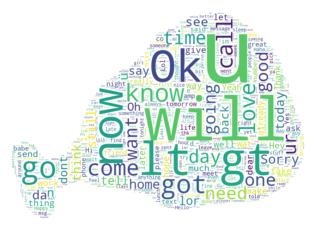

In [62]:
# all description text
wrds_cnt = " ".join(wrds for wrds in df_ham.message)
print ("There are {} unique words in all the descriptions.".format(len(wrds_cnt)))

# create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["cnt","cnt"])

# create word mask

mask_ham = np.array(Image.open('images/ham2.png'))

# create word cloud
wc_ham = WordCloud(stopwords=STOPWORDS,
               mask=mask_ham, background_color="white",
               max_words=2000, max_font_size=256,
               random_state=42, width=mask_ham.shape[1],
               height=mask_ham.shape[0])
wc_ham.generate(wrds_cnt)

# plot word cloud
plt.imshow(wc_ham, interpolation="bilinear")
plt.axis('off')
plt.show()

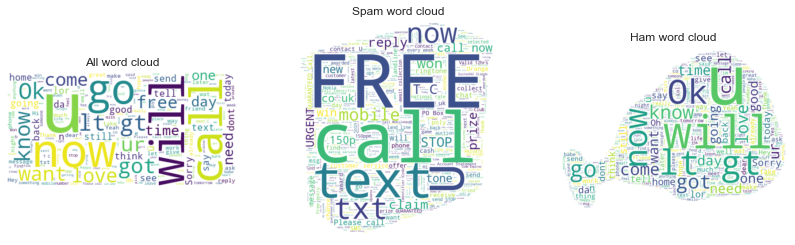

In [63]:
# combine all wordcloud plots
sns.set_style("white")
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14,4))
ax[0].imshow(wc_all, interpolation="bilinear")
ax[0].set_title('All word cloud')
ax[1].imshow(wc_spam, interpolation="bilinear")
ax[1].set_title('Spam word cloud')
ax[2].imshow(wc_ham, interpolation="bilinear")
ax[2].set_title('Ham word cloud')
fig.set_facecolor("white")
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
plt.savefig('images/cloud.png',bbox_inches='tight',dpi=400, pad_inches=0.1)
plt.show()

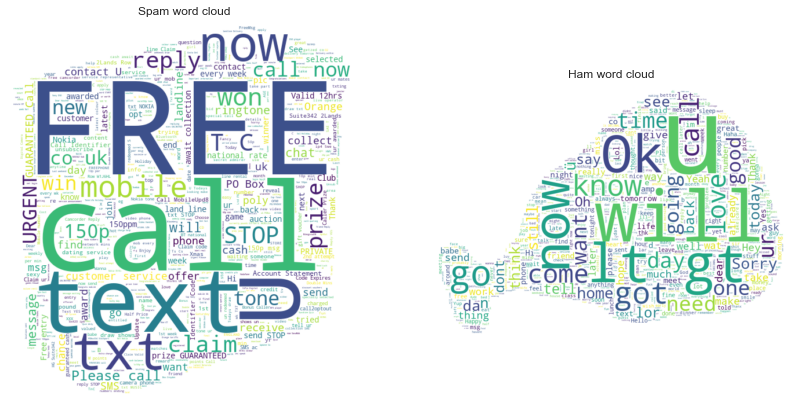

In [66]:
# combine all wordcloud plots
sns.set_style("white")
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,8))
ax[0].imshow(wc_spam, interpolation="bilinear")
ax[0].set_title('Spam word cloud')
ax[1].imshow(wc_ham, interpolation="bilinear")
ax[1].set_title('Ham word cloud')
fig.set_facecolor("white")
ax[0].axis('off')
ax[1].axis('off')
plt.savefig('images/cloud.png',bbox_inches='tight',dpi=400, pad_inches=0.1)
plt.show()

In [64]:
# def get_model(tokenizer, lstm_units):
#     """
#     Constructs the model,
#     Embedding vectors => LSTM => 2 output Fully-Connected neurons with softmax activation
#     """
#     # get the GloVe embedding vectors
#     embedding_matrix = get_embedding_vectors(tokenizer)
#     # we're going to define the model sequentially https://machinelearningmastery.com/keras-functional-api-deep-learning
#     model = Sequential()
#     # First, embed the words using loaded GloVe
#     model.add(Embedding(len(tokenizer.word_index)+1,
#               EMBEDDING_SIZE,
#               weights=[embedding_matrix],
#               trainable=False,
#               input_length=SEQUENCE_LENGTH))
#     # Add long short-term memory units
#     model.add(LSTM(lstm_units, recurrent_dropout=0.2))
#     # Add dropout to combat overfitting
#     model.add(Dropout(0.3))
#     # Add output dense layer with softmax for 1/0 classification
#     model.add(Dense(2, activation="softmax"))
#     # compile as rmsprop optimizer
#     # aswell as with recall metric
#     model.compile(optimizer="rmsprop", 
#                   loss="categorical_crossentropy",
#                   metrics=["accuracy", 
#                            tf.keras.metrics.Precision(), 
#                            tf.keras.metrics.Recall()])

#     model.summary()
#     return model
